In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

import scvelo as scv
import scanpy as sc
import anndata as an
import scvi
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

# Load expression

In [2]:
%%time

fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/imputed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 537 ms, sys: 2.93 s, total: 3.47 s
Wall time: 4.81 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_

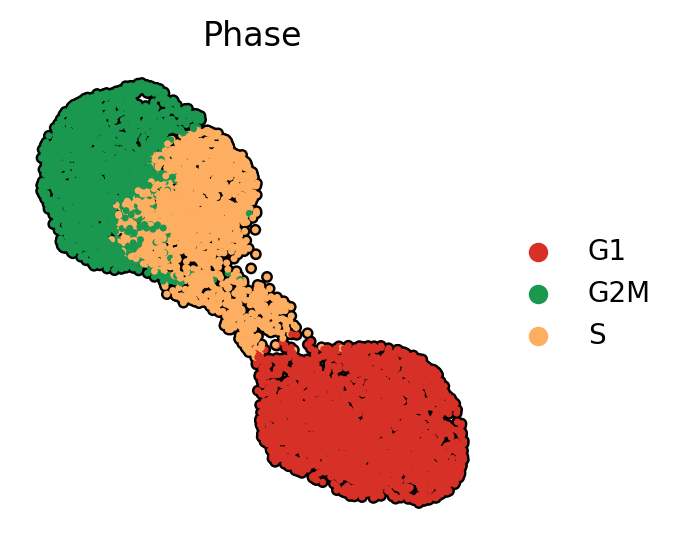

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

palette = {
    "G1": "#D73027",        
    "S": "#FDAE61",       
    "G2M": "#1A9850",    
    "unknown": "#B0B0B0", 
}
    
sc.pl.umap(
    adata,
    color='cluster_phase',
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    title='Phase',
    frameon=False,
    wspace=0.25,
)

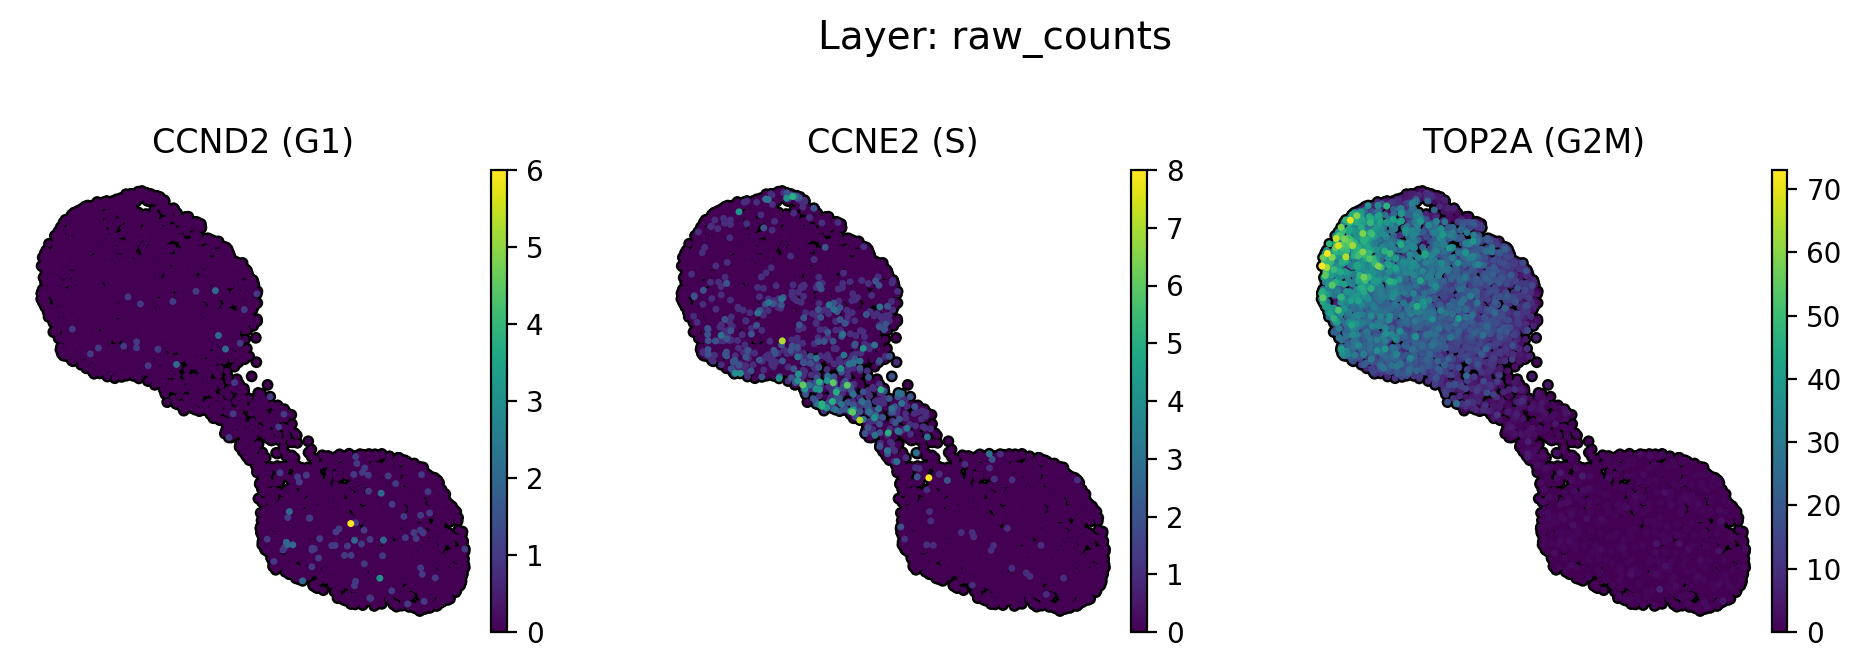

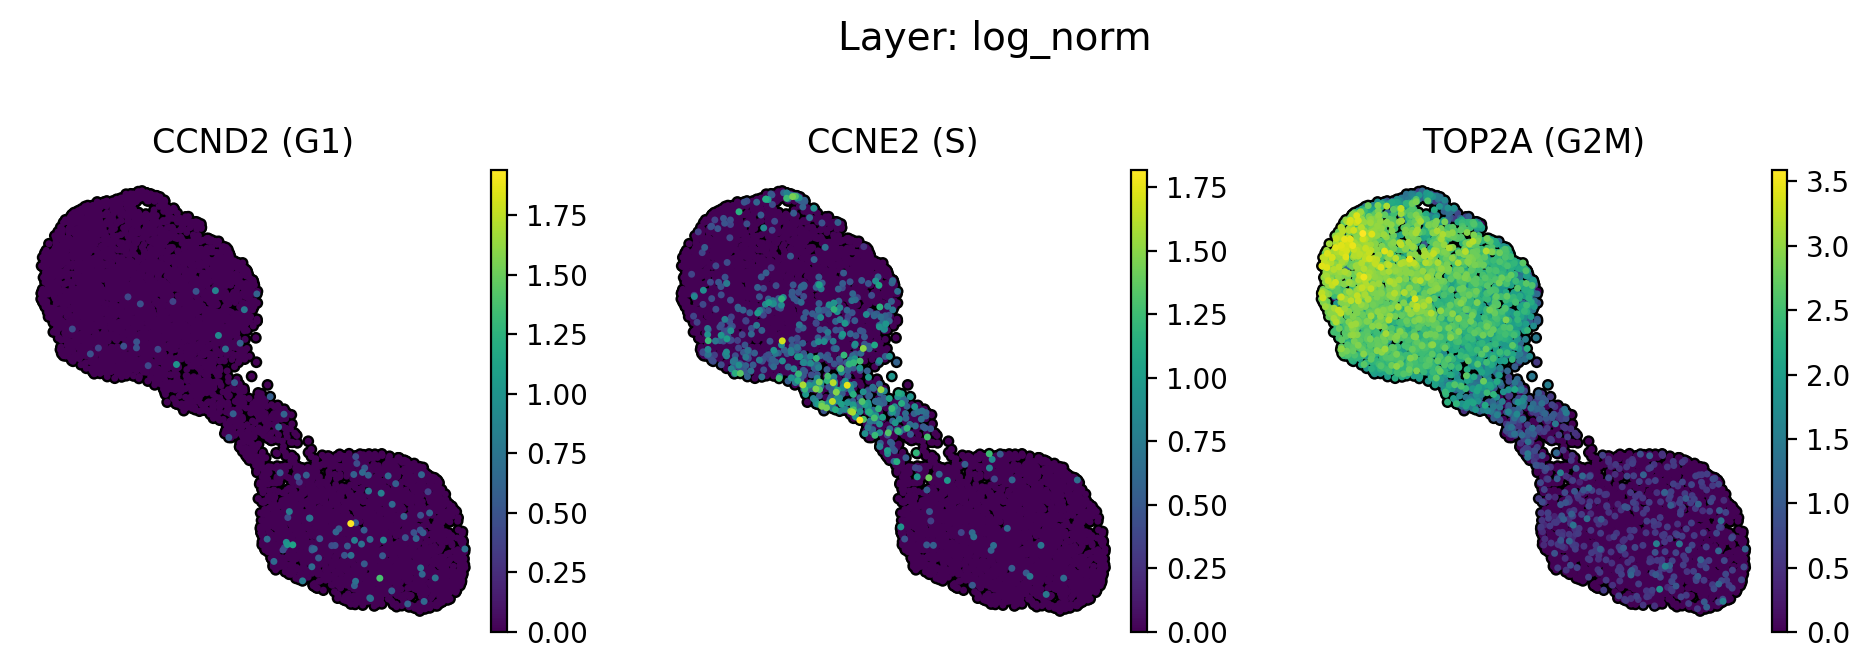

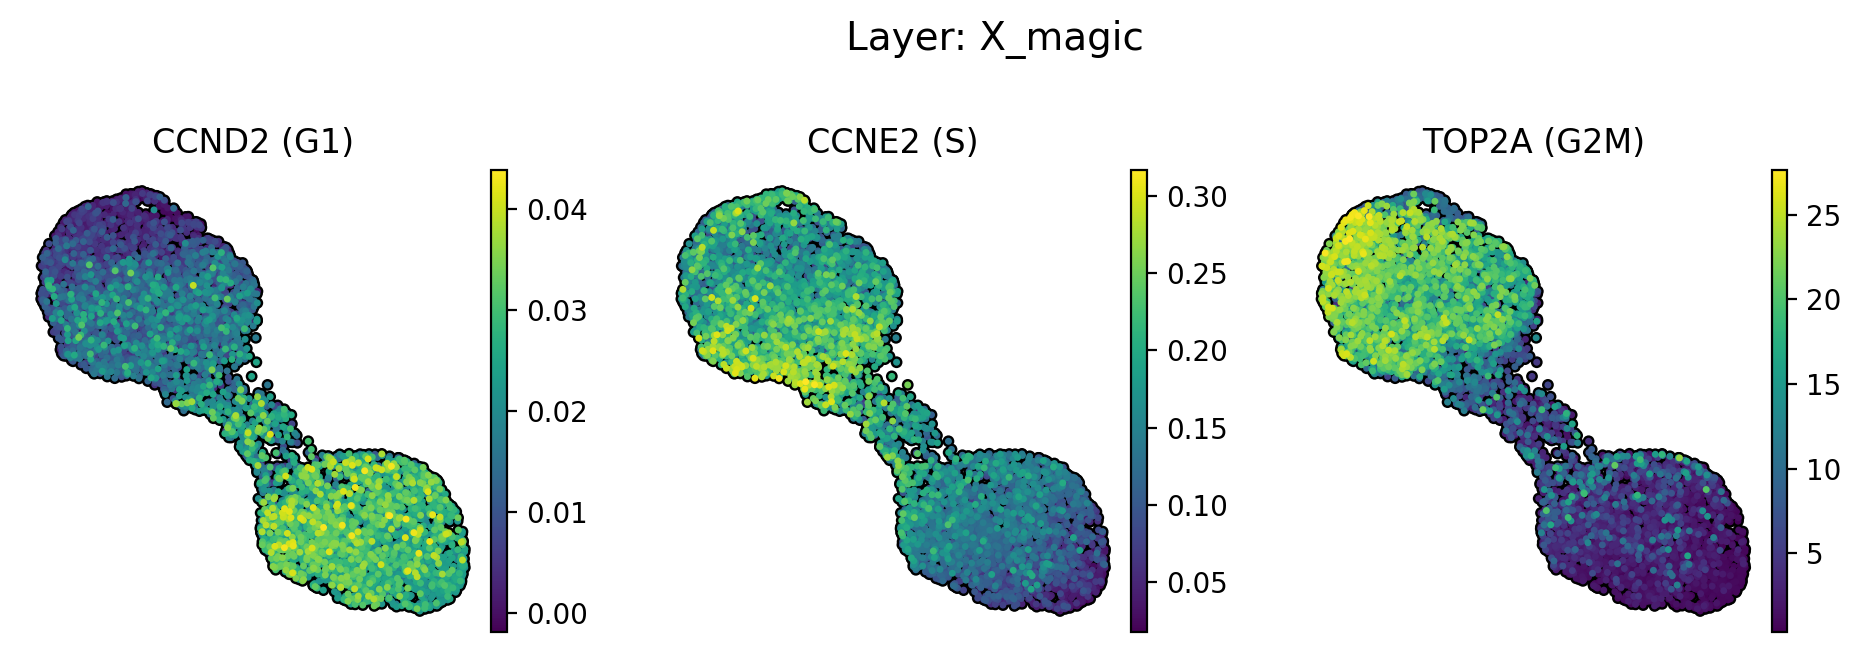

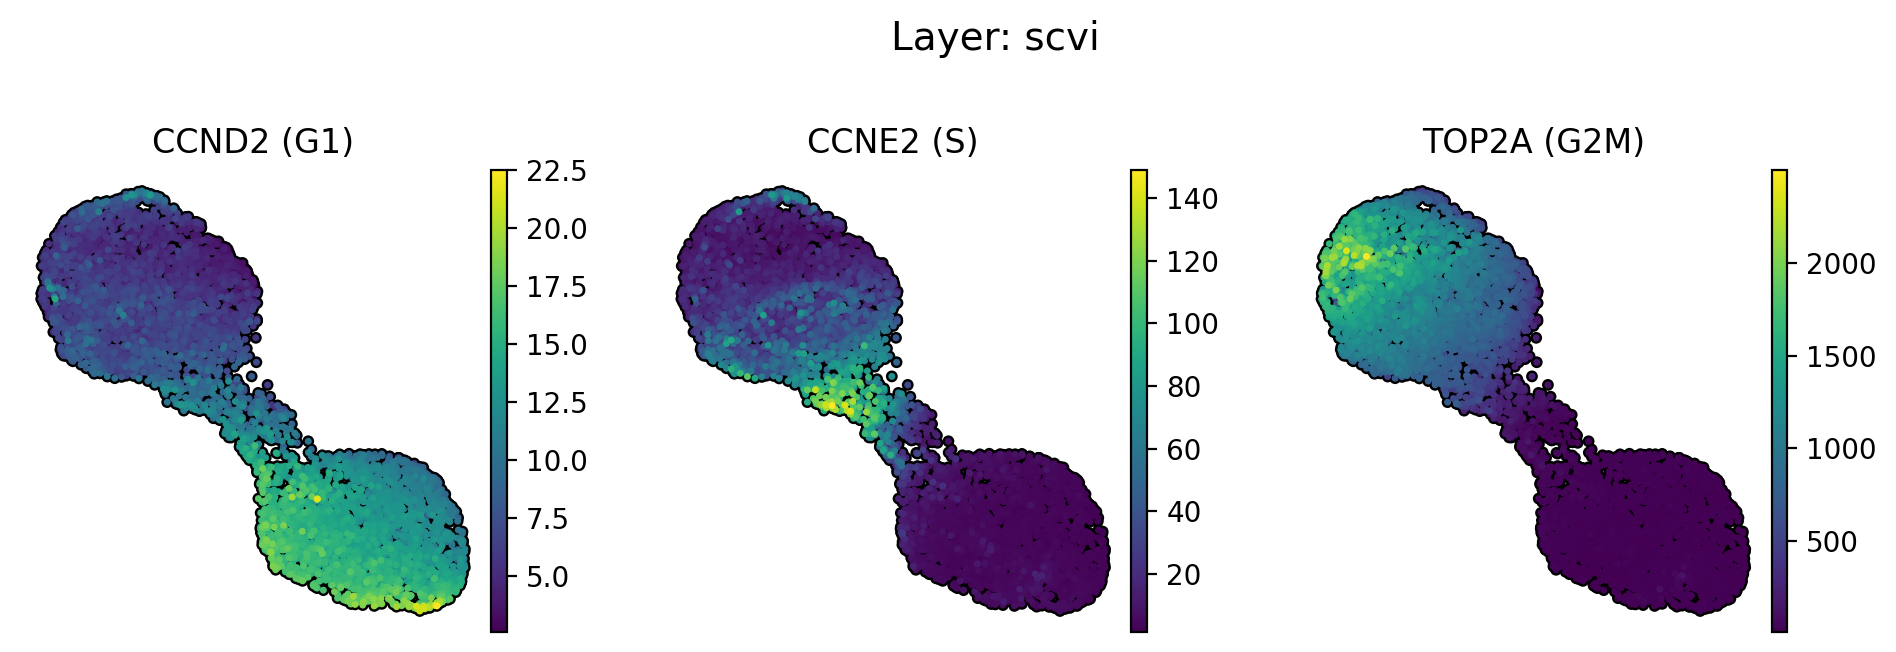

CPU times: user 3.08 s, sys: 121 ms, total: 3.2 s
Wall time: 3.21 s


In [4]:
%%time
genes = {
    "G1" : "CCND2",
    "S" : "CCNE2", 
    "G2M" : "TOP2A"  
}

titles = [f"{v} ({k})" for k, v in genes.items()]

for layer in ['raw_counts', 'log_norm',  'X_magic', 'scvi',]:


    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3, 3
    
    axes = sc.pl.umap(
        adata,
        color=genes.values(),
        size=25,
        ncols=3,
        alpha=1,
        use_raw=False,
        layer=layer,
        add_outline=True,
        outline_color=('k', 'k'),
        title=titles,
        frameon=False,
        wspace=0.25,
        return_fig=True,   # <- important
    )
    
    axes.figure.suptitle(f"Layer: {layer}", fontsize=14, y=1.15)
    plt.show()

# Pick Root Cell

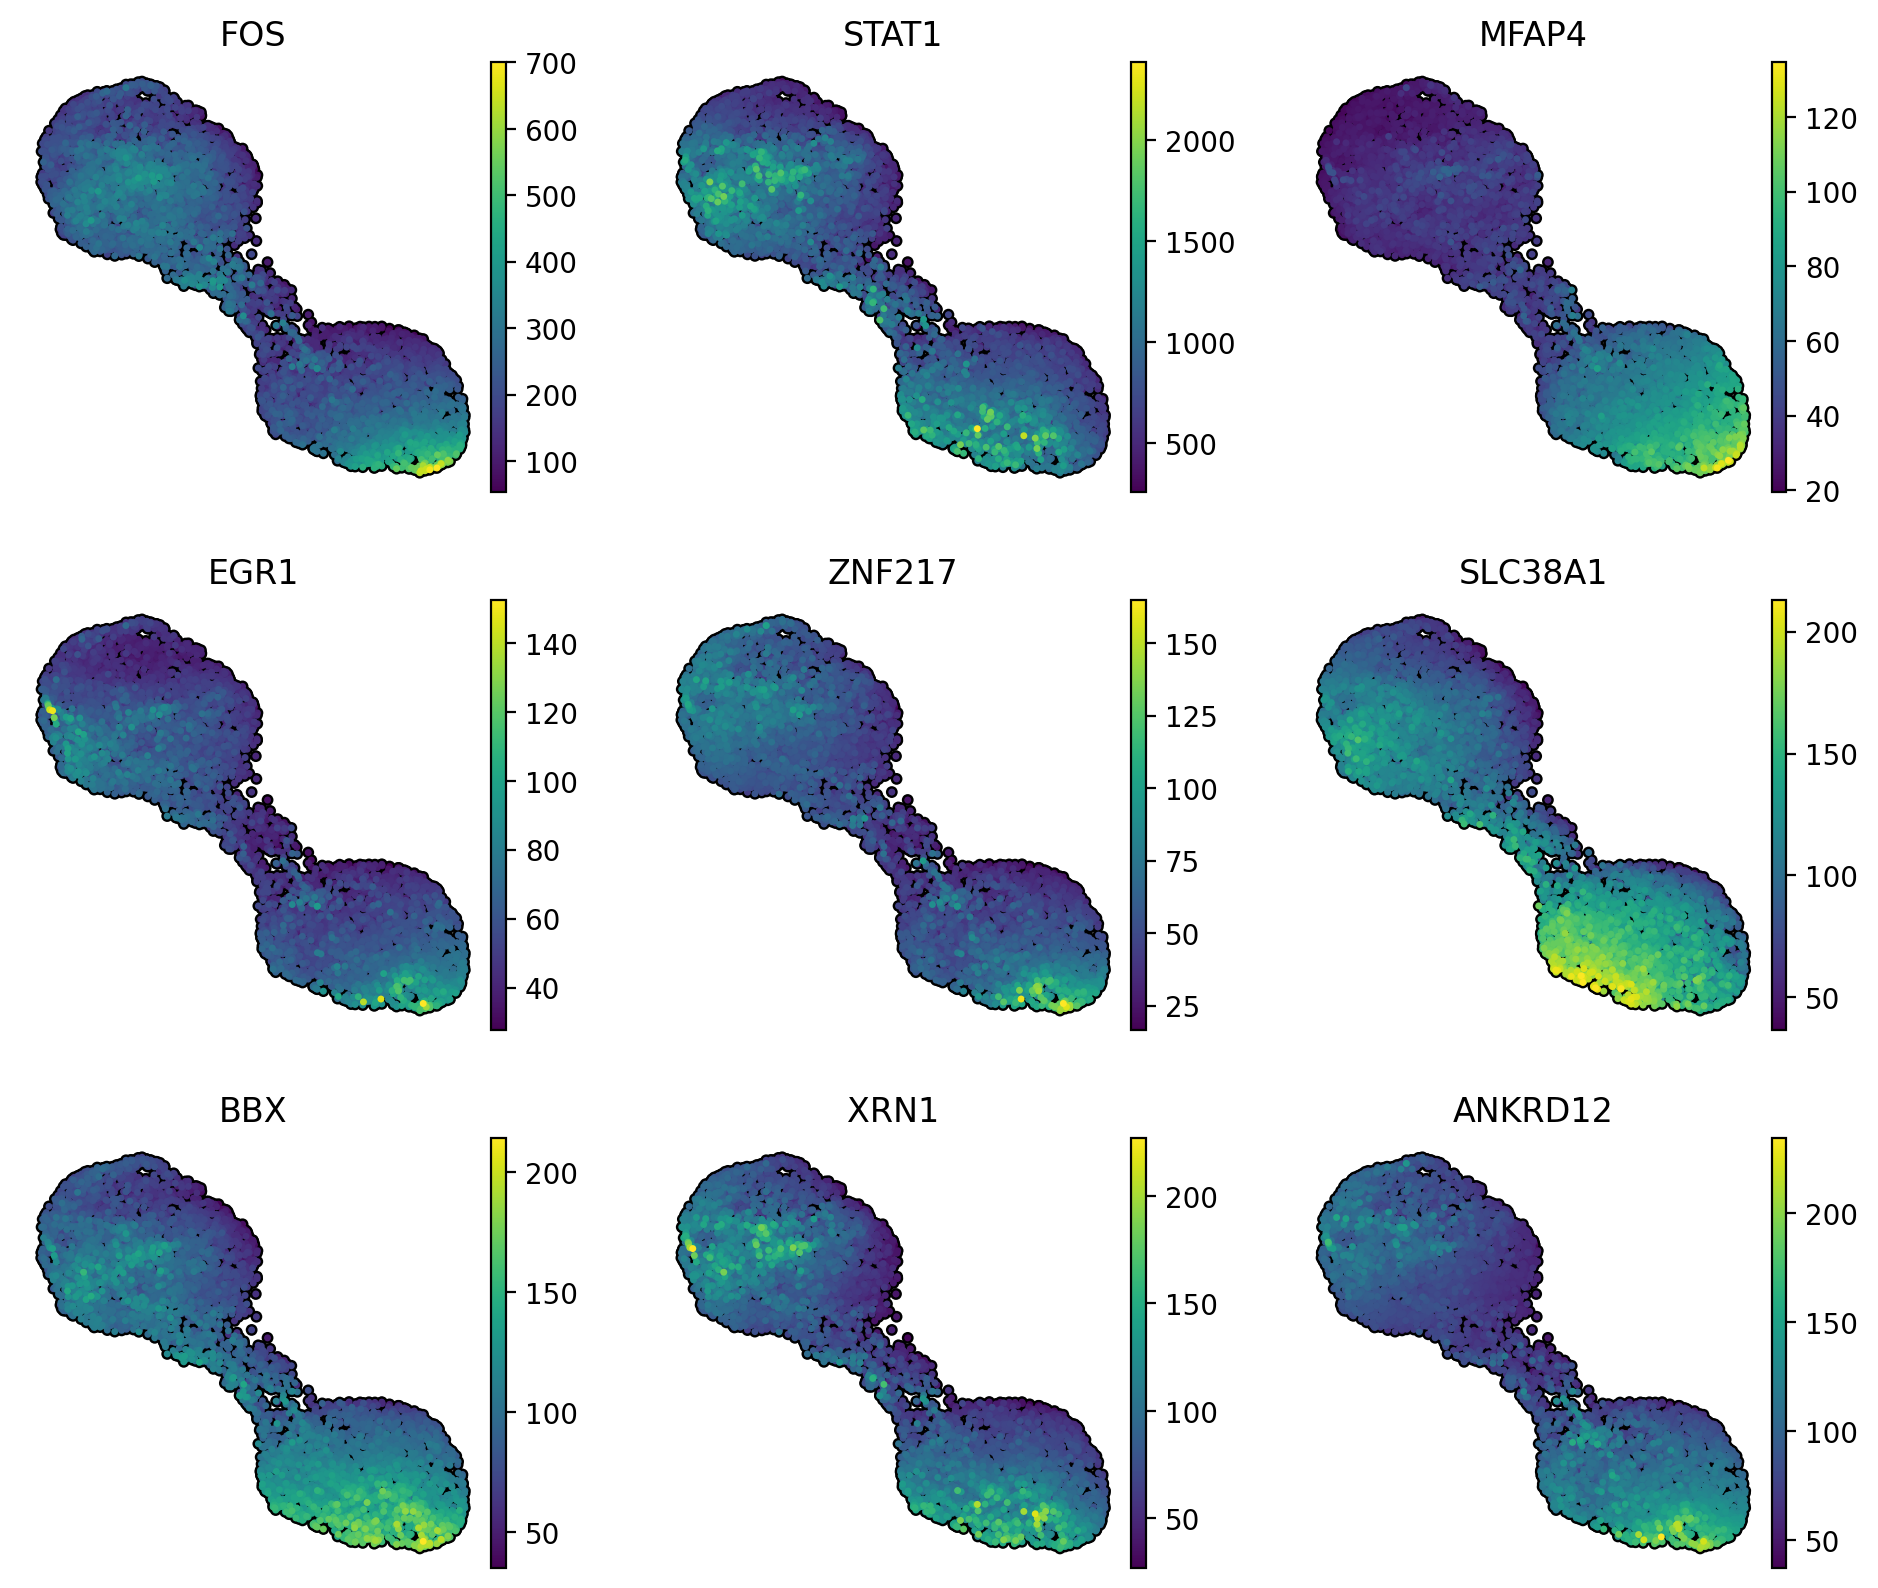

In [5]:
"""
Identify early G1 genes from: 
    M. J. Beyrouthy et al., “Identification of G1-Regulated Genes in Normally Cycling Human Cells,” PLOS ONE, vol. 3, no. 12, p. e3943, Dec. 2008

"""

genes = [
    "FOS", "STAT1", "MFAP4", "EGR1", "ZNF217",
    "SLC38A1","BBX","XRN1", "ANKRD12",
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)


85th percentile threshold: -89.29737726726535
G1_stage
nan      4013
late     2199
early     683
Name: count, dtype: int64


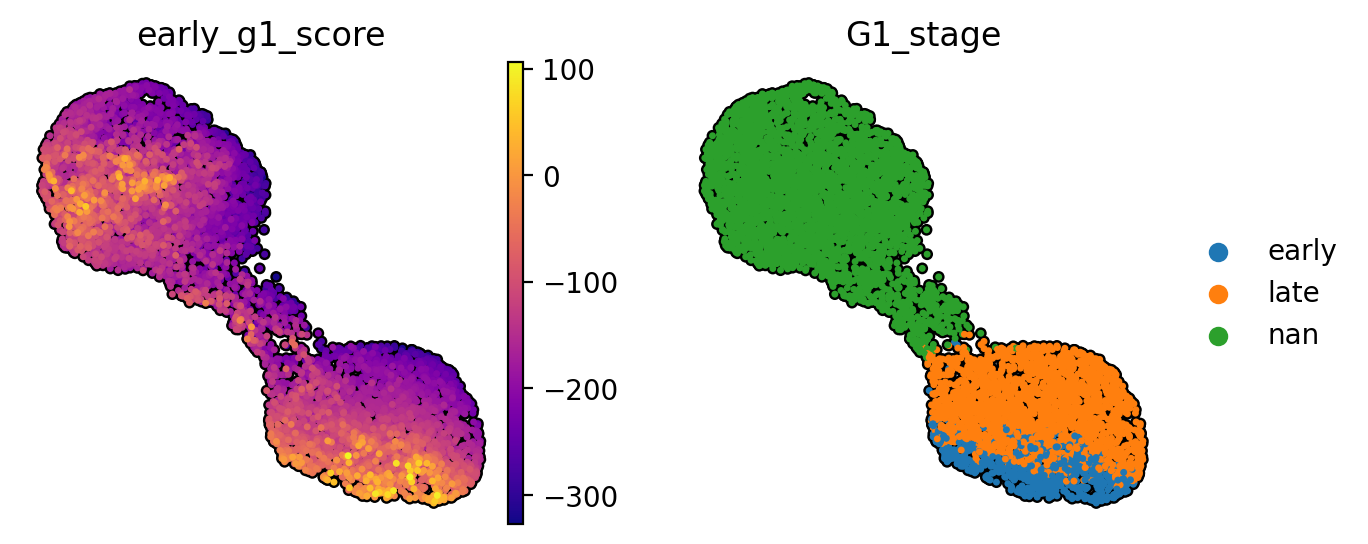

In [6]:
phase_column = 'cluster_phase' # could be cluster_phase instead

genes = [
    "FOS", "STAT1", "MFAP4", "EGR1", "ZNF217",
    "SLC38A1","BBX","XRN1", "ANKRD12",
]

# score cells by your gene set
sc.tl.score_genes(
    adata, 
    gene_list=genes,
    score_name="early_g1_score",
    use_raw=False,
    layer='scvi',
)

# compute threshold at the 85th percentile of the scores
threshold = np.percentile(adata.obs["early_g1_score"], 85)

# print threshold and distribution summary
print("85th percentile threshold:", threshold)

adata.obs["G1_stage"] = np.where(
    adata.obs[phase_column] == "G1",                       # only assign labels in G1
    np.where(adata.obs["early_g1_score"] > threshold, "early", "late"),
    np.nan                                            # non-G1 cells
)

print(adata.obs["G1_stage"].value_counts(dropna=False))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=['early_g1_score', 'G1_stage'],
    cmap='plasma',
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

# Establish Ordering

In [7]:
def find_closest_cell(adata, obs_key='G1_stage', value='early', obsm_key='X_scvi'):
    """
    Find the cell closest to a median vector in PCA space.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group
        value (str): The value for aggregation 
        obsm_key (str): Key in adata.obsm for PCA or other embedding.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest G1 cell in adata.obs_names
    """
    mask = adata.obs[obs_key] == value
    emb = adata.obsm[obsm_key][mask]

    median_vec = np.median(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index

find_closest_cell(adata)

('CAAGCCACAGCCATCT-1', 1996)

cell_id='CAAGCCACAGCCATCT-1' root_idx=1996


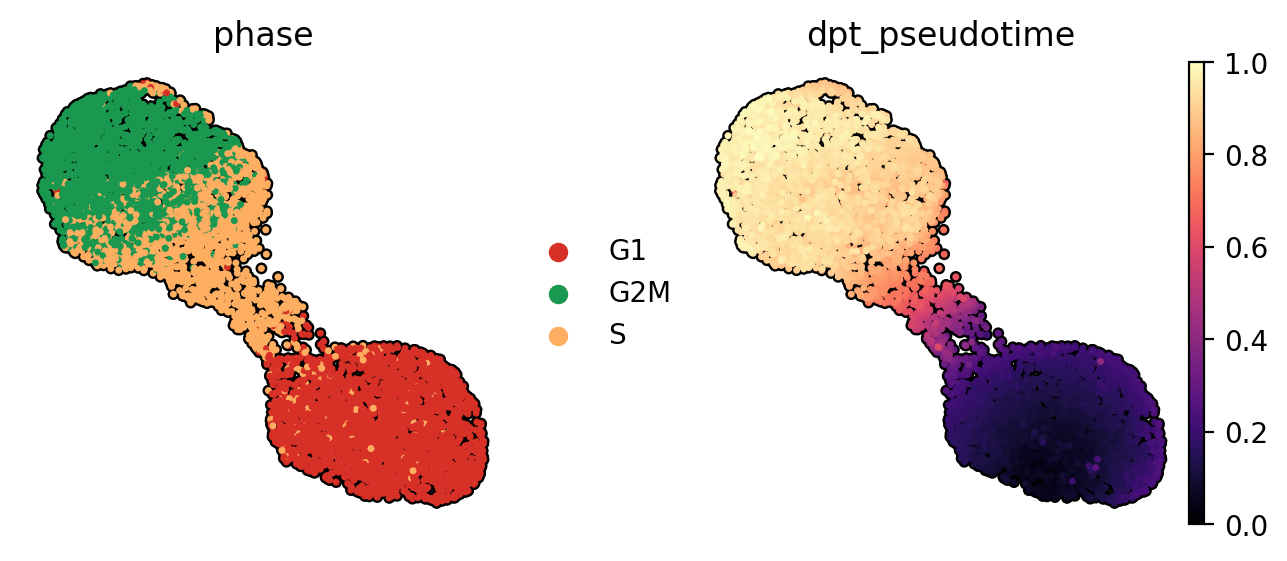

CPU times: user 9.71 s, sys: 431 ms, total: 10.1 s
Wall time: 7.27 s


In [8]:
%%time 
sc.pp.neighbors(adata, n_neighbors=75, use_rep='X_scvi')
sc.tl.diffmap(adata, n_comps=adata.obsm['X_scvi'].shape[1])

# choose representative cells from either G1 or G2M
cell_id, root_idx = find_closest_cell(
    adata, 
    obs_key='G1_stage', 
    value='early',
    obsm_key='X_scvi'
)

print(f"{cell_id=} {root_idx=}")

# set root and run pseudotime
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata, 
    color=['phase', 'dpt_pseudotime'],
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    na_in_legend=False,
    cmap='magma',
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    frameon=False,
)

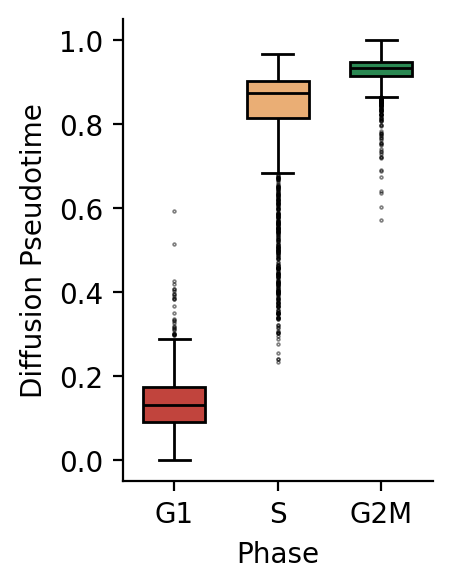

In [9]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

sns.boxplot(
    data=adata.obs,
    x='cluster_phase',
    y='dpt_pseudotime',
    hue='cluster_phase',
    palette=palette,
    linecolor='k',
    width=0.6,
    order=['G1', 'S', 'G2M'],
    flierprops={'markersize' : 0.6, 'alpha' : 0.5}
)

plt.ylabel('Diffusion Pseudotime')
plt.xlabel('Phase')

sns.despine()

# Convert to Ordering

CPU times: user 58.5 ms, sys: 1.18 ms, total: 59.7 ms
Wall time: 59.3 ms


<Axes: xlabel='dpt_pseudotime', ylabel='global_ordering'>

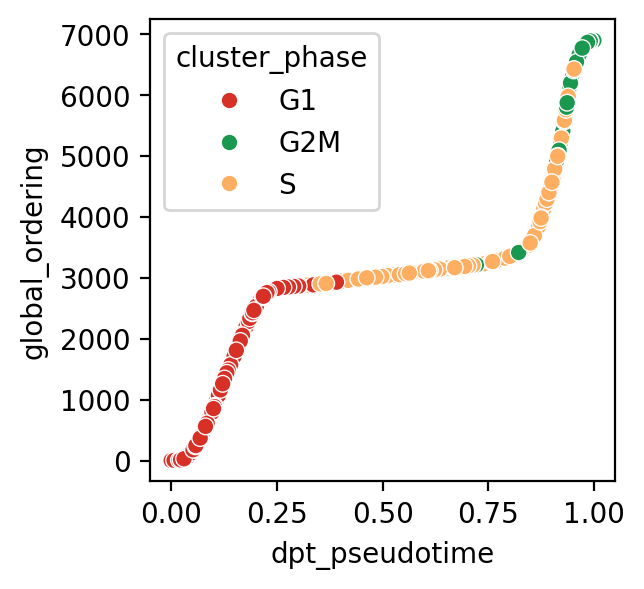

In [10]:
%%time
adata.obs['global_ordering'] = adata.obs['dpt_pseudotime'].rank(ascending=True)

adata.obs['global_ordering_bin'] = pd.cut(
    adata.obs['global_ordering'],bins=22, labels=False,
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(
    data=adata.obs,
    x=adata.obs['dpt_pseudotime'],
    y=adata.obs['global_ordering'],
    hue='cluster_phase',
    palette=palette,
)

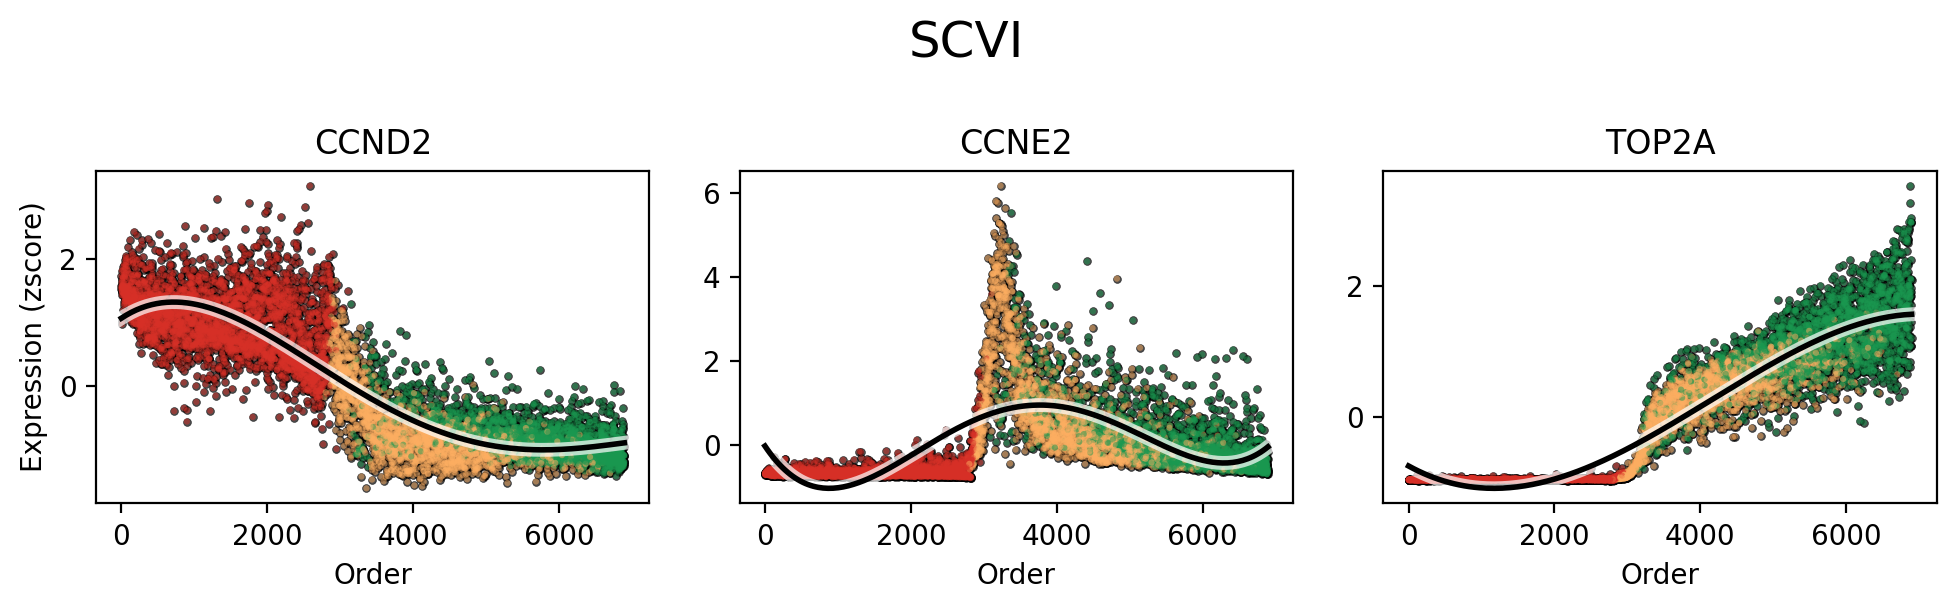

In [11]:
# layer = 'X_magic'
layer = 'scvi'

gene_names = [
    "CCND2", "CCNE2",  "TOP2A"  
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

fig, axes = plt.subplots(1, 3)
axes = axes.ravel()

for i, gene in enumerate(gene_names):
    y = adata[:, gene].layers[layer].ravel()
    y = zscore(y)
    x = adata.obs['global_ordering'].values

    sns.scatterplot(
        x=x,y=y,s=8,
        ec='k',c='k',
        alpha=0.7,
        ax=axes[i]
    )

    sns.scatterplot(
        x=x,y=y,s=5,
        ec='none',
        palette=palette,
        legend=False,
        alpha=0.5,
        hue=adata.obs[f'cluster_phase'],
        ax=axes[i]
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("Order")

    if i == 0:
        axes[i].set_ylabel("Expression (zscore)")

    # degree=4 polyfit
    coeffs = np.polyfit(x, y, deg=4)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = p(x_fit)

    # error estimate from residuals
    residuals = y - p(x)
    err = residuals.std()
    y_lower = y_fit - err
    y_upper = y_fit + err

    axes[i].plot(x_fit, y_fit, lw=5, color="w", alpha=0.7)
    axes[i].plot(x_fit, y_fit, lw=2, color="k")
    # axes[i].fill_between(x_fit, y_lower, y_upper, color="k", alpha=0.2)

fig.suptitle(layer.upper(), fontsize=18, y=1.0)
plt.tight_layout()

In [12]:
# layer = 'spliced'

# gene_names = [
#     "CCNE1", "CCNB1", "CCNE2", "CCNB2"
# ]

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# fig, axes = plt.subplots(2, 2)
# axes = axes.ravel()

# for i, gene in enumerate(gene_names):
#     y = adata[:, gene].layers[layer].todense().ravel()
#     y = zscore(y)
#     x = adata.obs['global_ordering'].values

#     sns.scatterplot(
#         x=x,y=y,s=3,
#         ec='none',
#         palette=palette,
#         legend=False,
#         c='k',
#         ax=axes[i]
#     )
#     axes[i].set_title(gene)
#     axes[i].set_xlabel("Order")

#     # degree=4 polyfit
#     coeffs = np.polyfit(x, y, deg=4)
#     p = np.poly1d(coeffs)
#     x_fit = np.linspace(x.min(), x.max(), 200)
#     y_fit = p(x_fit)

#     # error estimate from residuals
#     residuals = y - p(x)
#     err = residuals.std()
#     y_lower = y_fit - err
#     y_upper = y_fit + err

#     axes[i].plot(x_fit, y_fit, color="r")
#     axes[i].fill_between(x_fit, y_lower, y_upper, color="r", alpha=0.2)

# plt.tight_layout()

Text(0.5, 0.98, 'X_MAGIC')

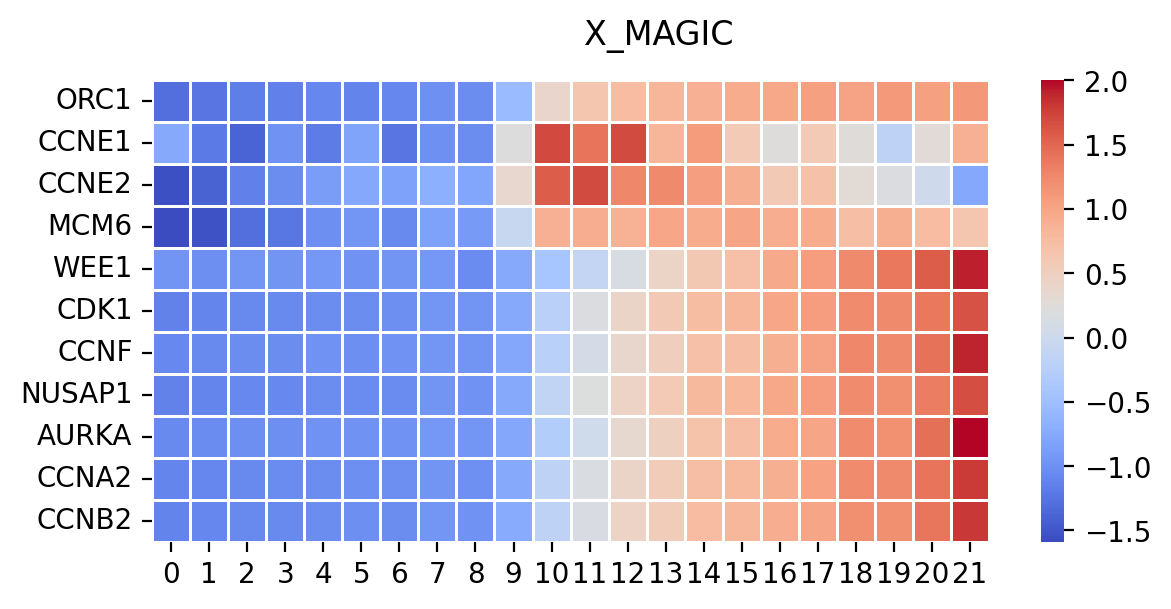

In [13]:
layer = 'X_magic'
# layer = 'scvi'

genes = [
    "ORC1","CCNE1","CCNE2",
    "MCM6","WEE1","CDK1",
    "CCNF","NUSAP1","AURKA",
    "CCNA2","CCNB2"
]

df = adata[:, genes].to_df(layer=layer)
df['global_ordering_bin'] = adata.obs['global_ordering_bin']

df = df.groupby('global_ordering_bin').median().T
df = df.apply(lambda x: zscore(x, nan_policy="omit"), axis=1, result_type="expand")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6.75, 3

sns.heatmap(
    df, lw=0.5, 
    cmap='coolwarm',
)

_ = plt.xticks(rotation=0)

plt.suptitle(layer.upper())

# RNA Velocity

Normalized count data: X, spliced, unspliced.
computing neighbors


<timed exec>:1: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:12) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.


/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=639580) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-

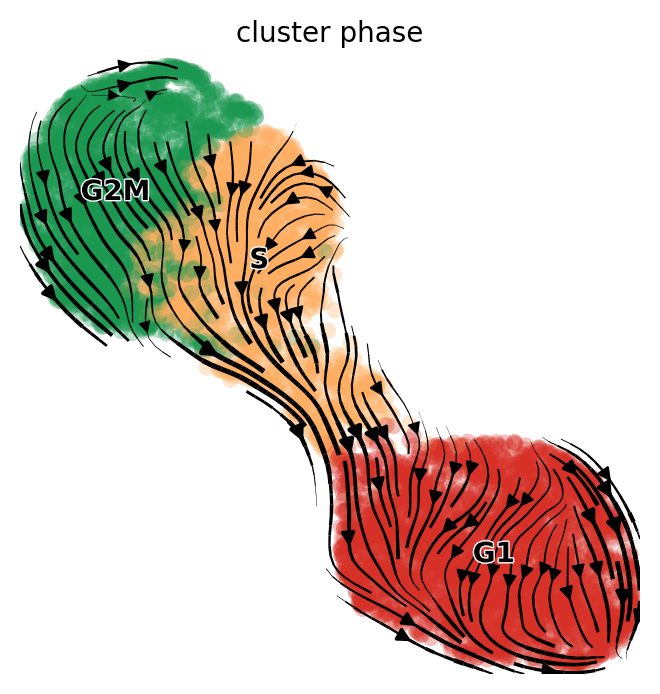

CPU times: user 51.5 s, sys: 10.9 s, total: 1min 2s
Wall time: 57.7 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

In [14]:
%%time

scv.pp.moments(adata, n_neighbors=100, use_rep='X_diffmap')
# scv.tl.recover_dynamics(adata)
# scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

scv.tl.velocity_pseudotime(adata, root_key=root_idx) # same root cell as pseudotime
# scv.tl.latent_time(adata, root_key=root_idx) # same root cell as pseudotime

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

scv.pl.velocity_embedding_stream(
    adata, 
    basis="umap", 
    color="cluster_phase",
)

adata

/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-

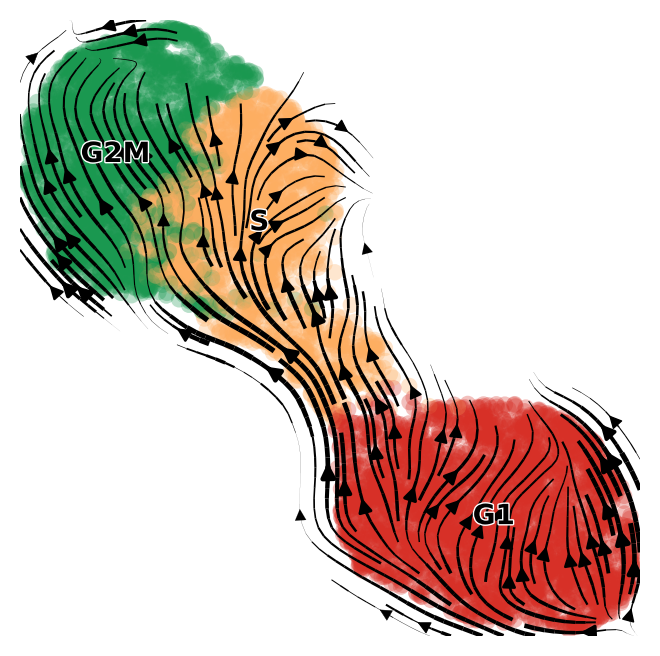

In [15]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

V = -np.array(adata.obsm["velocity_umap"])           

scv.pl.velocity_embedding_stream(
    adata,
    color='cluster_phase',
    V=V,
    smooth=0.8,
    title="",
)

# PCA on Imputed Data

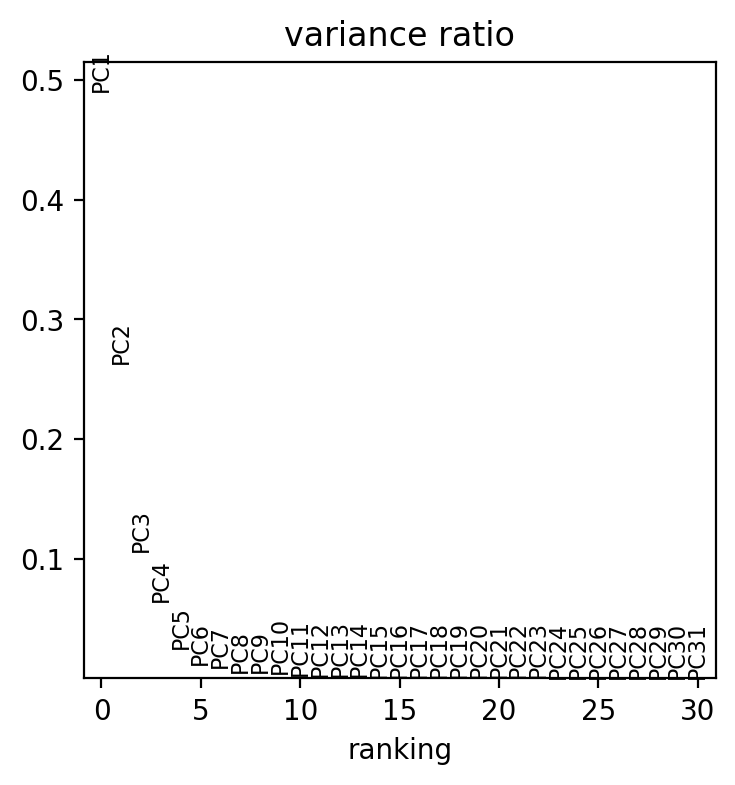

CPU times: user 3.83 s, sys: 230 ms, total: 4.07 s
Wall time: 1.06 s


In [16]:
%%time
sc.pp.pca(adata, layer='scvi')
sc.pl.pca_variance_ratio(adata)

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-

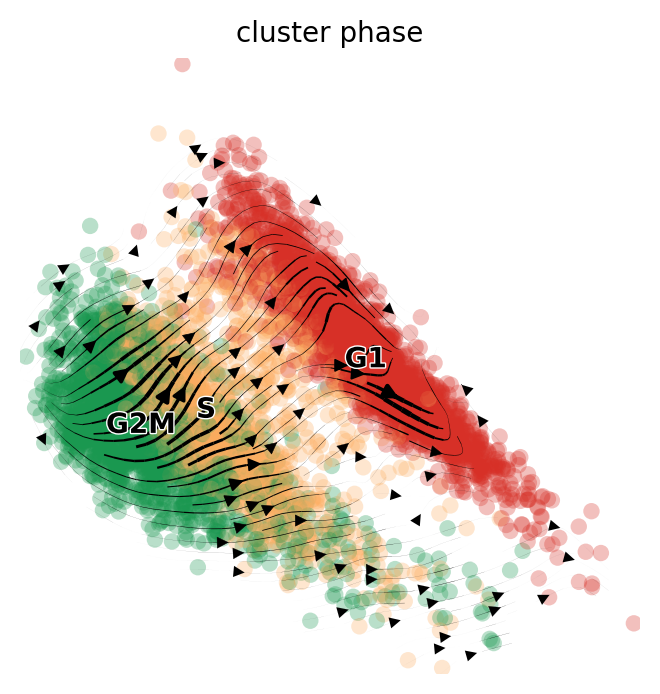

AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

In [17]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

scv.pl.velocity_embedding_stream(
    adata, 
    basis="pca", 
    color="cluster_phase",
)

adata

/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-

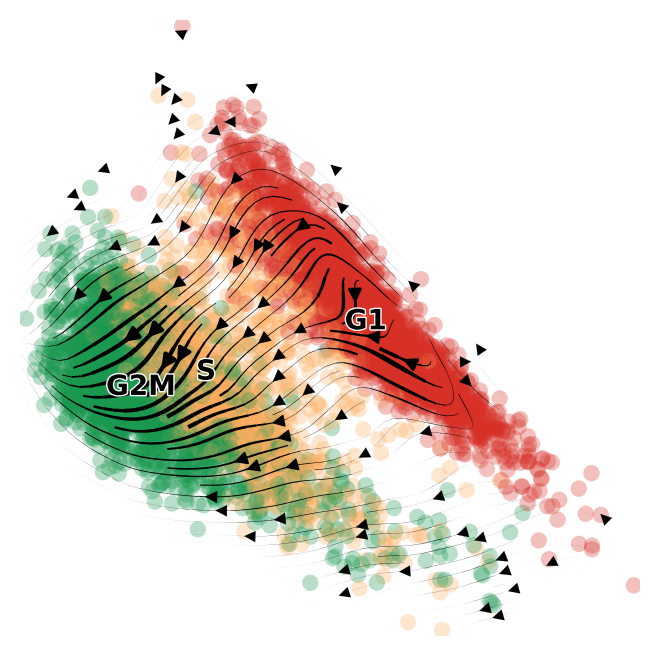

In [18]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

V = -np.array(adata.obsm["velocity_pca"])           

scv.pl.velocity_embedding_stream(
    adata,
    basis='pca',
    color='cluster_phase',
    V=V,
    smooth=0.8,
    title="",
)

In [19]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# scv.pl.scatter(
#     adata, 
#     color='latent_time',
#     color_map='gnuplot', 
#     size=80,
# )

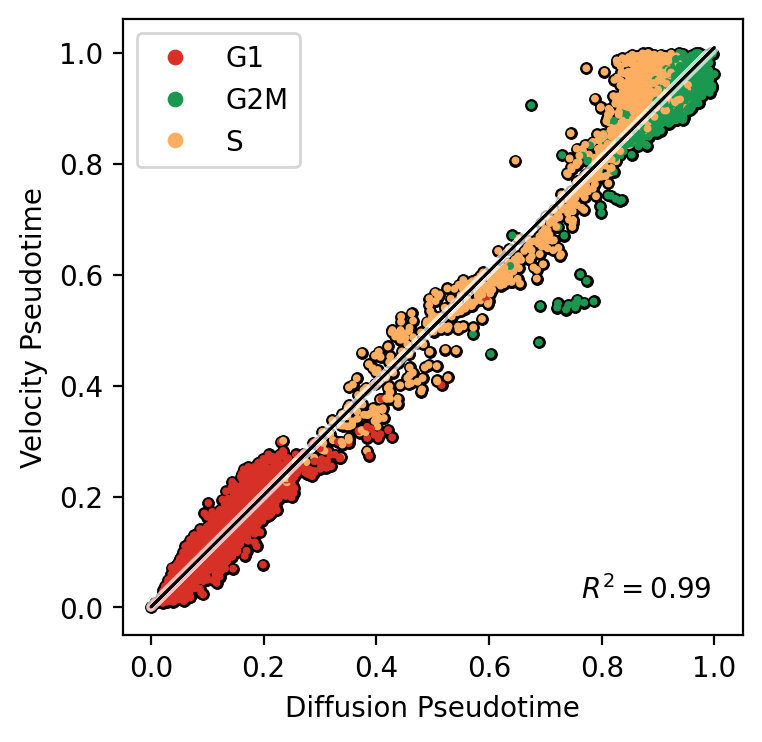

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4


sns.scatterplot(
    data=adata.obs,
    x='dpt_pseudotime',
    y='velocity_pseudotime',
    c='k',
    ec='k',
    s=18,
)

sns.scatterplot(
    data=adata.obs,
    x='dpt_pseudotime',
    y='velocity_pseudotime',
    hue='cluster_phase',
    palette=palette,
    ec='none',
    s=8,
)

plt.ylabel('Velocity Pseudotime')
plt.xlabel('Diffusion Pseudotime')

x = adata.obs['dpt_pseudotime'].values
y = adata.obs['velocity_pseudotime'].values

# fit straight line
m, b = np.polyfit(x, y, 1)

# plot line
plt.plot(x, m*x + b, color='w', lw=3.5, alpha=0.7)
plt.plot(x, m*x + b, color='k',  lw=1)

# compute R^2
r_sq = r2_score(y, m*x + b)

# add annotation in bottom right
plt.text(
    0.95, 0.05,                # x, y in axis fraction coordinates
    f"$R^2 = {r_sq:.2f}$",
    ha='right', va='bottom',
    transform=plt.gca().transAxes,
    fontsize=10
)

sns.move_legend(
    plt.gca(),
    loc='best',
    title="",
    markerscale=2,
)


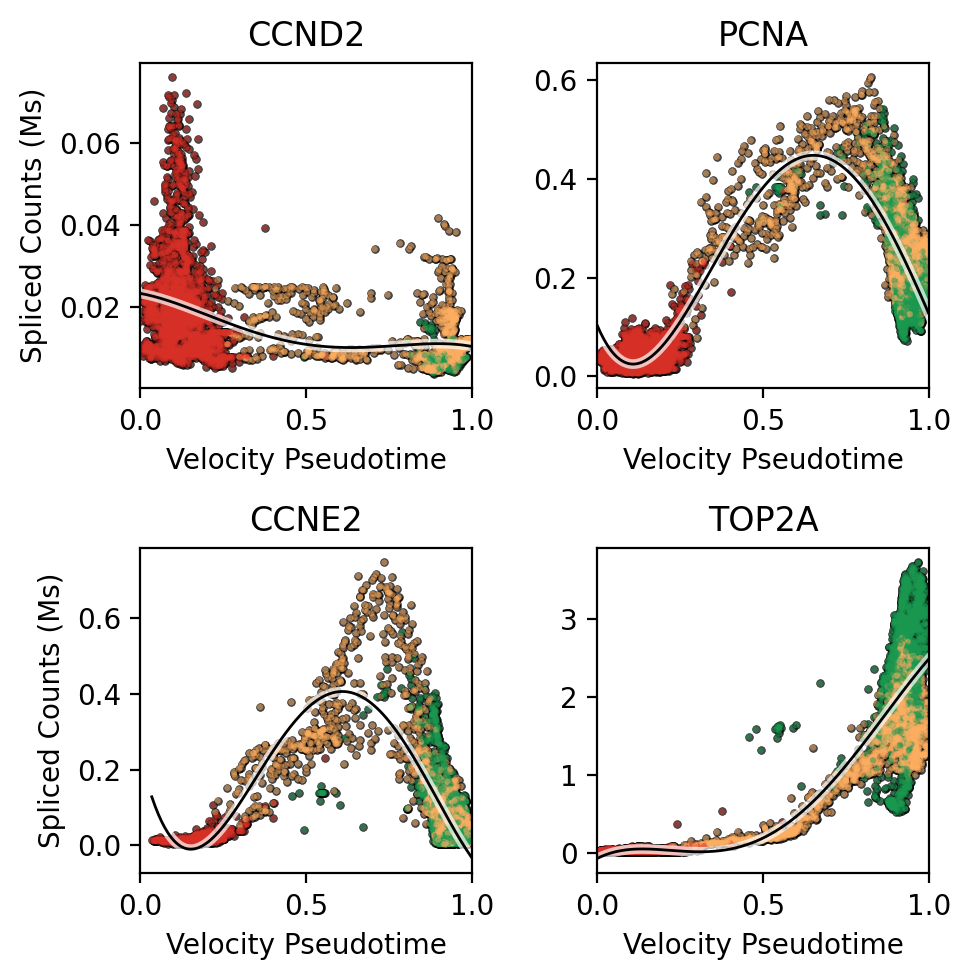

In [21]:
# layer = 'X_magic'
layer = 'Ms'

gene_names = ["CCND2", "PCNA", "CCNE2",  "TOP2A"]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

for i, gene in enumerate(gene_names):

    df = pd.DataFrame({
        'pseudotime' : adata.obs['velocity_pseudotime'].values,
        'gene' : adata[:, gene].layers[layer].ravel(),
        'phase' : adata.obs[f'cluster_phase'],
    })

    df['gene_norm'] = zscore(df['gene'])
    df = df[df['gene'] > 0]

    sns.scatterplot(
        data=df,
        x='pseudotime',
        y='gene',
        s=8,
        ec='k',
        c='k',
        alpha=0.7,
        legend=False,
        ax=axes[i]
    )

    sns.scatterplot(
        data=df,
        x='pseudotime',
        y='gene',
        s=5,
        ec='none',
        palette=palette,
        legend=False,
        alpha=0.5,
        hue='phase',
        ax=axes[i]
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("Velocity Pseudotime")
    axes[i].set_xlim([0, 1])

    if not i % 2 == 1:
        axes[i].set_ylabel("Spliced Counts (Ms)")
    else:
        axes[i].set_ylabel("")

    # degree=4 polyfit
    coeffs = np.polyfit(df['pseudotime'], df['gene'], deg=4)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(df['pseudotime'].min(), df['pseudotime'].max(), 200)
    y_fit = p(x_fit)
    axes[i].plot(x_fit, y_fit, lw=3.5, color="w", alpha=0.7)
    axes[i].plot(x_fit, y_fit, lw=1, color="k")


plt.tight_layout()

# Write out file

In [22]:
%%time
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata.write(outpath)
adata

CPU times: user 519 ms, sys: 3.82 s, total: 4.34 s
Wall time: 16.9 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra